In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

# Introduction

In this notebook we will build two models using two transformers. We will begin by building a Random Forest Classifier and a Logistic Regression with a Count Vectorizer. For our second iteration we will use the same model, but use a TFIDF vectorizer to compare the results of our first pair of models.

In [2]:
df = pd.read_csv('../Data/02_sub_reddit_data_clean.csv')

In [3]:
df.dtypes

id                      object
subreddit               object
title                   object
utc_datetime_str        object
num_comments             int64
day_name                object
title_word_count         int64
negative_score         float64
neutral_score          float64
positive_score         float64
compound_score         float64
removed_by_category     object
is_removed               int64
dtype: object

In [4]:
df.head(2)

,id,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score,removed_by_category,is_removed
0,z99f3w,AskMen,what do athlete think about having some things...,2022-12-01 01:03:02,21,Thursday,12,0.0,0.859,0.141,0.2023,NaN,0
1,z991l7,AskMen,Why is the idea of permanent sleep so appealing?,2022-12-01 00:47:36,38,Thursday,9,0.0,1.000,0.000,0.0000,deleted,1


In [5]:
X=df['title']
y=df['subreddit']

In [6]:
baseline = y.value_counts(normalize=True)
baseline

AskWomen    0.504575
AskMen      0.495425
Name: subreddit, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=.25, stratify=y)

In [9]:
def scores(y_test, preds):
    '''
    This function will be used to evaluate the scores of our model.
    '''
    print(f'Recall Score: {recall_score(y_test, preds, average="macro")}')
    print(f'F1 score: {f1_score(y_test, preds, average="macro")}')
    print(f'precision score: {precision_score(y_test, preds, average="macro")}')
    print(f'accuracy score: {accuracy_score(y_test, preds)}')

# Random forest with CountVectorizer

In [10]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer())
    ,('rt', RandomForestClassifier())
])

In [11]:
cross_val_score(pipe_rf, X_train, y_train, cv=3).mean()

0.6883594809219445

In [12]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('rt', RandomForestClassifier())])

In [13]:
print(f' Training score is {pipe_rf.score(X_train, y_train)}')
print(f' Test score is {pipe_rf.score(X_test, y_test)}')

 Training score is 0.9961262831687003
 Test score is 0.705574912891986


In [14]:
pipe_rf_params = {
    'cvec__lowercase': [True],
    'cvec__max_features': [30, 50, 75.],
    'cvec__min_df': [2, 3, 9],
    'cvec__max_df': [0.80, 0.90],
    'cvec__ngram_range': [(1, 2), (2,3), (3,4)],
    'cvec__stop_words' : ['english', None],
    'rt__min_samples_leaf': [3, 5, 6],
    'rt__max_depth': [10, 15, 20],
    'rt__bootstrap': [True]
    
}

In [15]:
gs_rf = GridSearchCV(pipe_rf,
                 param_grid=pipe_rf_params,
                 cv=5, n_jobs = -1)

In [ ]:
gs_rf.fit(X_train, y_train)

In [17]:
display(gs_rf.best_params_)

{'cvec__lowercase': True,
 'cvec__max_df': 0.8,
 'cvec__max_features': 50,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'rt__bootstrap': True,
 'rt__max_depth': 20,
 'rt__min_samples_leaf': 3}

Best parmas for a countvector and random forest

|Param|setting|
|-----|-----|
|cvec_lowercase|True|
|cvec__max_df| .9|
|cvec__max_features| 50|
|cvec__min_df| 9|
|cvec__ngram_range| (1, 2)|
|cvec__stop_words| None|
|rt__bootstrap| True|
|rt__max_depth| 10|
|rt__min_samples_leaf| 6|

In [18]:
print(f' Training score is {gs_rf.score(X_train, y_train)}')
print(f' Test score is {gs_rf.score(X_test, y_test)}')

 Training score is 0.789463490218865
 Test score is 0.6881533101045296


In [19]:
gs_rf.score(X_train, y_train)

0.789463490218865

In [20]:
gs_rf.score(X_test, y_test)

0.6881533101045296

In [21]:
preds_rf = gs_rf.predict(X_test)

<Figure size 1500x1500 with 0 Axes>

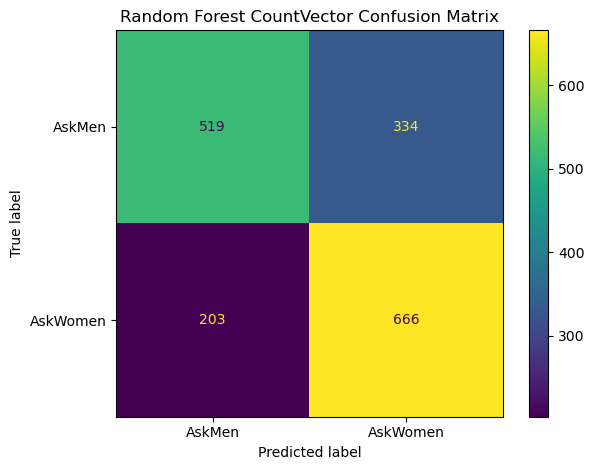

In [71]:
plt.figure(figsize=(15,15))
rf_matrix = ConfusionMatrixDisplay.from_estimator(gs_rf, X_test, y_test)
rf_matrix.ax_.set_title("Random Forest CountVector Confusion Matrix")
plt.tight_layout()
plt.savefig('../Figures/confusion_matrix/rf_cvec_confusion_matrix.png')

In [23]:
scores(y_test, preds_rf)

Recall Score: 0.6874194779948115
F1 score: 0.6858640984483682
precision score: 0.6924182825484765
accuracy score: 0.6881533101045296


In [24]:
rf_model_1 = gs_rf

In [25]:
with open('../Models/model_pickel1.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(rf_model_1, pickle_out)

This model does better than baseline, but is slightly overfit. It also has a misclassified ~33% of the predictions for Askwomen and ~27% of the predictions for Askmen. With a recall score and accuracy score of 69% this model does okay, but is not suitable for large scale use.

# Logistic regresion with countvectorizor

In [26]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer())
    ,('logr', LogisticRegression())
])

In [ ]:
pipe_logr.fit(X_train, y_train)

In [28]:
pipe_logr.score(X_train, y_train)

0.8894053844663955

In [29]:
pipe_logr.score(X_test, y_test)

0.6782810685249709

In [30]:
pipe_logr_params = {
    'cvec__lowercase': [True],
    'cvec__max_features': [30, 50, 75.],
    'cvec__min_df': [2, 3, 9],
    'cvec__max_df': [0.80, 0.90],
    'cvec__ngram_range': [(1, 2), (2,3), (3,4)],
    'cvec__stop_words' : ['english', None],
    'logr__C':[.25, .5, .75, 1]
}

In [31]:
gs_logr = GridSearchCV(pipe_logr, param_grid=pipe_logr_params, cv=3,n_jobs=-1)

In [ ]:
gs_logr.fit(X_train,y_train)

In [33]:
display(gs_logr.best_params_)

{'cvec__lowercase': True,
 'cvec__max_df': 0.8,
 'cvec__max_features': 30,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'logr__C': 0.25}

Best parmas for a countvector and logistic regression

|Param|setting|
|-----|-----|
|cvec__lowercase|True|
|cvec__max_df| .8|
|cvec__max_features| 30|
|cvec__min_df| 2|
|cvec__ngram_range| (1, 2)|
|cvec__stop_words| None|
|logr_C| .25|


In [34]:
gs_logr.score(X_train, y_train)

0.6529149719155529

In [35]:
gs_logr.score(X_test,y_test)

0.6637630662020906

After adding the penality term, the logistic regression was much less fit. The performance is similar to our random forest which was overfit, so this model may be better. We will have to see its recall score to compare.

In [36]:
preds_logr = gs_logr.predict(X_test)

<Figure size 1500x1500 with 0 Axes>

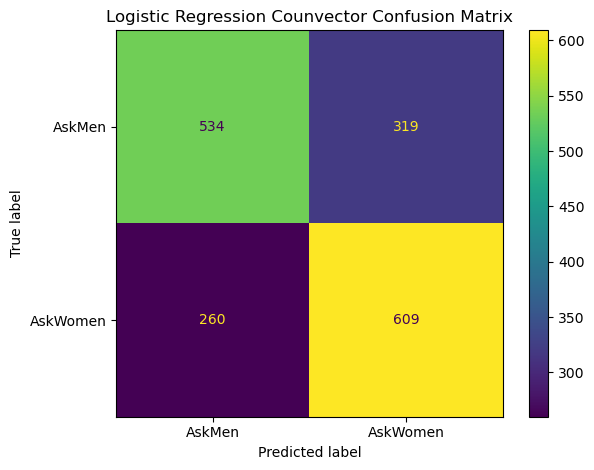

In [72]:
plt.figure(figsize=(15,15))
log_matrix = ConfusionMatrixDisplay.from_estimator(gs_logr, X_test, y_test)
log_matrix.ax_.set_title("Logistic Regression Counvector Confusion Matrix")
plt.tight_layout()
plt.savefig('../Figures/confusion_matrix/logr_cvec_confusion_matrix.png')

In [76]:
scores(y_test, preds_logr)

Recall Score: 0.663415657457535
F1 score: 0.6631240288154818
precision score: 0.664397040302267
accuracy score: 0.6637630662020906


Here we notice a 3% lower recall score, which is not much of an difference. This model is better at predicting Askmen, but does worse with Askwomen. In this case the model is making more predictions for Askmen, so any increase is negligible. Next we will see if using the TFIDF Vectorizer will improve performance. In theory it should perform better because its comparing the title (document) to the whole subreddit (corpus).

# Random forest with TF-IDF Vectorizer 

In [39]:
pipe_rf_tf = Pipeline([
    ('tf',TfidfVectorizer())
    ,('rt', RandomForestClassifier())
])

In [40]:
cross_val_score(pipe_rf_tf, X_train, y_train, cv=3).mean()

0.6794499322099554

In [41]:
pipe_rf_tf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('rt', RandomForestClassifier())])

In [42]:
print(f' Training score is {pipe_rf_tf.score(X_train, y_train)}')
print(f' Test score is {pipe_rf_tf.score(X_test, y_test)}')

 Training score is 0.9961262831687003
 Test score is 0.7009291521486644


In [43]:
pipe_rf_tf_params = {
    'tf__lowercase': [True],
    'tf__max_features': [30, 50, 75.],
    'tf__min_df': [2, 3, 9],
    'tf__max_df': [0.80, 0.90],
    'tf__ngram_range': [(1, 2), (2,3), (3,4)],
    'tf__stop_words' : ['english', None],
    'rt__min_samples_leaf': [3, 5, 6],
    'rt__max_depth': [10, 15, 20],
    'rt__bootstrap': [True]
    
}

In [44]:
gs_rf_tf = GridSearchCV(pipe_rf_tf, param_grid=pipe_rf_tf_params, cv=3, n_jobs=-1)

In [ ]:
gs_rf_tf.fit(X_train, y_train)

In [46]:
gs_rf_tf.best_params_

{'rt__bootstrap': True,
 'rt__max_depth': 10,
 'rt__min_samples_leaf': 6,
 'tf__lowercase': True,
 'tf__max_df': 0.9,
 'tf__max_features': 30,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': None}

Best parmas for a TFID and random forest

|Param|setting|
|-----|-----|
|tf__max_df| .9|
|tf__max_features| 30|
|tf__min_df| 3|
|tf__ngram_range| (1, 2)|
|tf__stop_words| None|
|tf__lowercase| True|
|rt__bootstrap| True|
|rt__max_depth| 10|
|rt__min_samples_leaf| 6|

In [47]:
print(f' Training score is {gs_rf_tf.score(X_train, y_train)}')
print(f' Test score is {gs_rf_tf.score(X_test, y_test)}')

 Training score is 0.7135386403253922
 Test score is 0.6747967479674797


It appears the model did not improve much with the classification rate after incorporating the TFIDF. We will see if it has a recall score to when we used the countvectorizer

In [48]:
preds_rf_tf = gs_rf_tf.predict(X_test)

<Figure size 1500x1500 with 0 Axes>

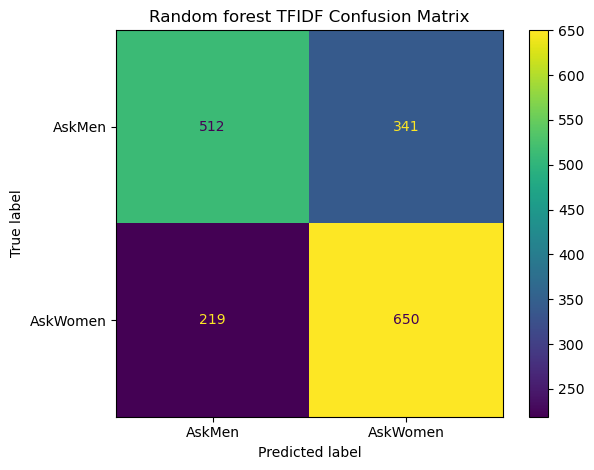

In [66]:
plt.figure(figsize=(15,15))
rf_tf_matrix = ConfusionMatrixDisplay.from_estimator(gs_rf_tf, X_test, y_test)
rf_tf_matrix.ax_.set_title("Random forest TFIDF Confusion Matrix")
plt.tight_layout()
plt.savefig('../Figures/confusion_matrix/Random_forest_tfidf_confusion_matrix')

In [50]:
scores(y_test, preds_rf_tf)

Recall Score: 0.6741103288063384
F1 score: 0.6726946888237211
precision score: 0.6781567624351034
accuracy score: 0.6747967479674797


Her we see a similar recall score (.67~) compared to our random forest and counvectorizer (.69). There's not much of an improvement here, the subreddits may be too similar to differentiate. We will see if there's any improvement with our logistical regression using a TF-IDF vectorizer.

# Logistic regression with TF-IDF Vectorizer 

In [51]:
pipe_logr_tf = Pipeline([
    ('tf', TfidfVectorizer())
    ,('logr', LogisticRegression())
])

In [52]:
pipe_logr_tf_params = {
    'tf__lowercase': [True],
    'tf__max_features': [30, 50, 75.],
    'tf__min_df': [2, 3, 9],
    'tf__max_df': [0.80, 0.90],
    'tf__ngram_range': [(1, 2), (2,3), (3,4)],
    'tf__stop_words' : ['english', None],
    'logr__C':[.25, .5, .75, 1]
}

In [53]:
cross_val_score(pipe_logr_tf, X_train, y_train, cv=3).mean()

0.6668603525082316

In [54]:
gs_logr_tf = GridSearchCV(pipe_logr_tf, param_grid=pipe_logr_tf_params, cv=3, n_jobs=-1)

In [55]:
pipe_logr_tf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('logr', LogisticRegression())])

In [56]:
print(f' Training score is {pipe_logr_tf.score(X_train, y_train)}')
print(f' Test score is {pipe_logr_tf.score(X_test, y_test)}')

 Training score is 0.8332364904125509
 Test score is 0.6927990708478513


In [ ]:
gs_logr_tf.fit(X_train, y_train)

In [58]:
print(f' Training score is {gs_logr_tf.score(X_train, y_train)}')
print(f' Test score is {gs_logr_tf.score(X_test, y_test)}')

 Training score is 0.6560139453805927
 Test score is 0.6695702671312428


<Figure size 1500x1500 with 0 Axes>

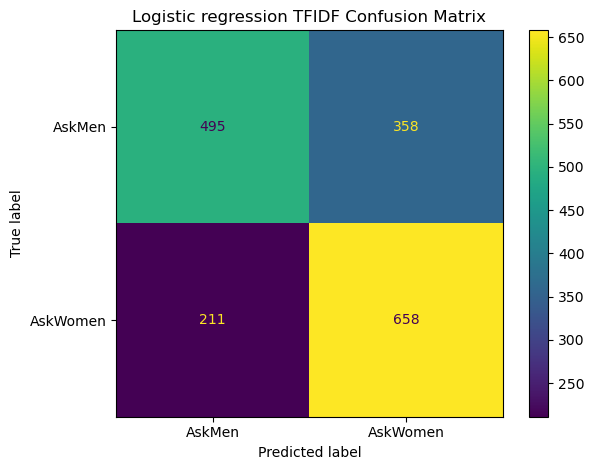

In [67]:
plt.figure(figsize=(15,15))
logr_tf_matrix = ConfusionMatrixDisplay.from_estimator(gs_logr_tf, X_test, y_test)
logr_tf_matrix.ax_.set_title("Logistic regression TFIDF Confusion Matrix")
plt.tight_layout()
plt.savefig('../Figures/confusion_matrix/Logistic_tfidf_confusion_matrix')

In [60]:
preds_logr_tf = gs_logr_tf.predict(X_test)

In [61]:
scores(y_test, preds_logr_tf)

Recall Score: 0.6687484907393793
F1 score: 0.6665828431814587
precision score: 0.6743854698757556
accuracy score: 0.6695702671312428


Again we notice a slight improvement in predicting Askwomen, but that is only because it is making more Askwomen predictions. Overall these models are performing with the same accuracy. Any modifications only results in a slightly higher true positive for one subreddit, but again that was only due to the model making more predictions for that sub reddit.

# Conclusion

Here we built 2 models using 2 different transformers. We used the models logistic regression and random forest with the transformers Countvectorizer and TFIDF transformers. In out findings we found consistent recall scores within the 60% ranges. Our models were pretty consistent with our classifications and changing the model or transformer had marginal differences in the models performance. 

Even with modifying the n_gram ranges of our transformers, the best parameter seemed to be 1 to 2 word grams. According to our EDA process, the most popular topics within these subreddits are too common so there will be some misclassification. Our model only does slightly better than our baseline score of 50% Askwomen and 49% Askmen. Because of the small difference in performance these models are not usable for research purposes. These subreddits may be too similar and we are unable to get more accuracy at this time.

# Recommendations

With our current models we cannot accurately predict which subreddit a post belongs too. For future revisions, one thing we can do is removed the top common words used in each subreddits to better differentiate them.

We can also experiment with a model that does not include removed posts, this can potentially be more representative of the respective subreddits since more people interact with these threads. Additionally, we can focus on the thread and the comments instead of starting with categorizing the thread title only. Perhaps by seeing how users interact with a post we can get a better understand of identifiable interactions.

Another use of our data set is we can build is a model to automatically identify post that should be removed. Because about 60% of our initial data was been removed we can use that as training data to build a model. We can do this by identifying what key terms in removed titles, and hopefully predict the probability of being classified as a removed post. This can either be shared with each subreddit's moderation team or with reddit's trust and safety team to better assist their community moderators.

# Limitations

1) Too many removed post, almost half of our post were removed, so those post were potentially not representative of the subreddit.

2) The subreddits were too similar, when looking at the distribution of some of the features we fond most of them to have similar distributions.

3) The subreddits are question based, so there is little room for distinguishing features.
